# Random Forest
Total dataset size: 134 samples <br>
Training set: 134 samples

Features used (after importance analysis):
- LTA precipitation (mmpa)
- LTA wet days
- LTA_PET_mm
- Aridity idx
- NDVI
- DEM
- LTA soil moisture - 10 cm (kg m-2) 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
%matplotlib inline
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import rasterio
from utils import getAllCoordinates
import json
from sklearn.model_selection import cross_val_score

# Prepare all BGS points as training points

# read file (data + coordinates)
file = pd.read_csv('High_res_data_01/poc_01.csv')
# OMIT ZERO RECHARGE SAMPLES
file = file[file['Recharge_mmpa']!= 0.1]
#file = file[file['Recharge_mmpa']< 800]
# drop unimportant columns
data = file.drop(columns=['ID', 'Lat', 'Long', 'Landcover_ext', 'DEM'])
# Labels are the values we want to predict
labels = np.log10(data['Recharge_mmpa'])
data = data.drop('Recharge_mmpa', axis = 1)
# Add for reference
data['ID'] = file['ID']
# Saving feature names for later use
feature_list = list(data.columns)
# Convert to numpy array
features = np.array(data)

In [2]:
correlation_matrix = data.corr()
correlation_matrix

,LTA_CHIRPS_mmpa,LTA_PET_mm,Aridity,NDVI,SM10_m3m3,ID
LTA_CHIRPS_mmpa,1.000000,-0.702025,0.962439,0.832917,0.933620,-0.004506
LTA_PET_mm,-0.702025,1.000000,-0.769824,-0.819225,-0.772056,0.057241
Aridity,0.962439,-0.769824,1.000000,0.845862,0.944013,-0.037339
NDVI,0.832917,-0.819225,0.845862,1.000000,0.808676,-0.003046
SM10_m3m3,0.933620,-0.772056,0.944013,0.808676,1.000000,-0.024519
ID,-0.004506,0.057241,-0.037339,-0.003046,-0.024519,1.000000


# Run RF for the whole domain

### Find hyperparameters

In [3]:
from sklearn.model_selection import RandomizedSearchCV

estimator = RandomForestRegressor()
# Number of trees in random forest
n_estimators = [2000] * 10
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 0.33]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              }

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=estimator, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(features[:, :-1], labels)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': None}

In [2]:
# get all coordinates of the smallest raster - workaround as rasters have slightly different shapes
coords, T0, out_shape = getAllCoordinates('High_res_data_01/NDVI_Afr_01.tif', grid=0.1)
coords_np = np.array([*coords])

# read rasters
pet_src = rasterio.open('High_res_data_01/LTA_PET_Afr_01.tif')
p_src = rasterio.open('High_res_data_01/LTA_CHIRPS_clipped_01.tif')
ndvi_src = rasterio.open('High_res_data_01/NDVI_Afr_01.tif')
ai_src = rasterio.open('High_res_data_01/LTA_AI_Afr_01_scaled.tif')
sm_src = rasterio.open('High_res_data_01/Soil_moisture_Afr_01.tif')

# get raster values at 0.5x0.5 grid + flatten
pet_samples = [item for sublist in list(pet_src.sample(coords)) for item in sublist]
p_samples = [item for sublist in list(p_src.sample(coords)) for item in sublist]
ndvi_samples = [item for sublist in list(ndvi_src.sample(coords)) for item in sublist]
ai_samples = [item/10000 for sublist in list(ai_src.sample(coords)) for item in sublist]
sm_samples = [item for sublist in list(sm_src.sample(coords)) for item in sublist]

In [5]:
# combine predictors in a dataframe
raw_ds = pd.DataFrame({'LTA_CHIRPS_mmpa': p_samples, 'LTA_PET_mm': pet_samples, 'Aridity': ai_samples, 
                       'NDVI': ndvi_samples, 
                       'SM10_m3m3': sm_samples, 'Lat': coords_np[:,0], 'Lon': coords_np[:,1]
                      })

# take rows with valid predictor data (land only)
filtered_ds = raw_ds[(raw_ds['LTA_CHIRPS_mmpa'] >= 0) & (raw_ds['LTA_PET_mm'] >= -1000) 
                     & (raw_ds['Aridity'] >= -1000) & (raw_ds['NDVI'] >= -1000) 
                     & (raw_ds['SM10_m3m3'] > 0)]

# convert dataframe to numpy array
domain_features = np.array(filtered_ds)[:,:-2]

## Run random forest regression

In [6]:
# instantiate random forest model
final_rf = RandomForestRegressor(**rf_random.best_params_, oob_score=True)
# train the model on entire BGS dataset
final_rf.fit(features[:,:-1], labels)
# use the forest's predict method on the whole domain
pred_recharge = final_rf.predict(domain_features)
# apply to training set again
train_predictions = final_rf.predict(features[:,:-1])

In [7]:
print(f'OOB score {final_rf.oob_score_}')

OOB score 0.6477937728838912


In [8]:
# merge with the features dataframe and back transform
filtered_ds['pred_recharge_mmpa'] = 10**pred_recharge
# fill gaps in the dataframe - revert to 0.1x0.1 grid
reindx_ds = filtered_ds.reindex(range(len(raw_ds)), fill_value=-9999)
recharge_grid = np.array(reindx_ds['pred_recharge_mmpa']).reshape(out_shape)

# attempt to save to a raster
# config
out_meta = {'driver': 'GTiff', "dtype": 'float32', "height": recharge_grid.shape[0], "width": recharge_grid.shape[1],
            "count": 1, "transform": T0, 'nodata': -9999, 'crs': rasterio.crs.CRS({"init": "epsg:4326"})}

# save
with rasterio.open("High_res_data_01/RF_recharge_01.tif", "w", **out_meta) as dest:
#with rasterio.open("High_res_data_01/RF_recharge_01_zero.tif", "w", **out_meta) as dest:
    dest.write(recharge_grid[np.newaxis, :, :])

<ipython-input-8-ce9468f54079>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ds['pred_recharge_mmpa'] = 10**pred_recharge


In [9]:
# Get numerical feature importances
importances = list(final_rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most Aimportant first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: LTA_CHIRPS_mmpa      Importance: 0.38
Variable: SM10_m3m3            Importance: 0.28
Variable: Aridity              Importance: 0.25
Variable: NDVI                 Importance: 0.06
Variable: LTA_PET_mm           Importance: 0.04


In [10]:
print(f'Max predicted recharge: {10**np.max(pred_recharge)}')

Max predicted recharge: 312.99538464339275


In [11]:
# report R-squared based on fivefold cross validation
print(f'R-squared based on fivefold cross-validation: {np.mean(cross_val_score(final_rf, features[:,:-1], labels, cv=5))}')

R-squared based on fivefold cross-validation: 0.6289730924961756


## Result comparison
- random forest (RF)
- random forest with residual kriging (RK RF)
- linear mixed model (created in R) (LMM)

In [3]:
# compare BGS linear model and random forest
point_coords = [(i,j) for (i,j) in zip(file['Long'], file['Lat'])]
obs = file['Recharge_mmpa']
rf_rech_src = rasterio.open('High_res_data_01/RF_recharge_01.tif')
rk_rf_rech_src = rasterio.open('High_res_data_01/R_RKRF_recharge_01.tif')
lmm_rech_src = rasterio.open('High_res_data_01/LMM_recharge_01.tif')

rf_rech_samples = [item for sublist in list(rf_rech_src.sample(point_coords, indexes=1)) for item in sublist]
rk_rf_rech_samples = [item for sublist in list(rk_rf_rech_src.sample(point_coords, indexes=1)) for item in sublist]
lmm_rech_samples = [item for sublist in list(lmm_rech_src.sample(point_coords)) for item in sublist]

summary = pd.DataFrame({'Lon': file['Long'], 'Lat': file['Lat'], 'Observations': obs, 'RF': rf_rech_samples,
                        'RK RF': rk_rf_rech_samples,'LMM': lmm_rech_samples})

summary.index.names = ['ID']
summary.index += 1
print(summary)
summary.to_csv("summary_01.csv")

       Lon    Lat  Observations          RF       RK RF         LMM
ID                                                                 
1     4.48   8.49         253.0  195.469421  208.532913  179.735519
2    30.09 -20.27          22.0   22.114092   21.930527   23.657877
3    32.96   0.46         245.0  233.299637  227.754288  148.877533
4    39.82  13.54         185.0   39.482677   55.079914   70.805649
5     2.30   6.50         120.0  188.697403  186.046707  161.525070
..     ...    ...           ...         ...         ...         ...
130  27.70 -26.00         100.0  109.505348  108.303322   50.759296
131  30.55 -17.71          80.0   52.803898   64.831497   69.592346
132 -17.00  14.72           8.0    9.955276   11.136485   14.492933
133  38.64   9.40         160.0  132.534164  150.987442  152.531647
134  33.74  -5.96          41.0   42.449764   40.777740   42.656673

[127 rows x 6 columns]


In [13]:
# problem: some observations are outside of the domain!
print(summary[(summary['LMM'] < 0) | (summary['RF'] < 0)])
# ignore these point for now
summary = summary[(summary['LMM'] >= 0) & (summary['RF'] >= 0)]

print('\nR squared')
print('LMM vs obs R^2:', metrics.r2_score(np.log10(summary['Observations'].values), np.log10(summary['LMM'].values)))
print('RF vs obs R^2:', metrics.r2_score(np.log10(summary['Observations'].values), np.log10(summary['RF'].values)))
print('RK RF vs obs R^2:', metrics.r2_score(np.log10(summary['Observations'].values), np.log10(summary['RK RF'].values)))

print('RF vs LMM R^2:', metrics.r2_score(np.log10(summary['RF'].values), np.log10(summary['LMM'].values)))
print('RK RF vs LMM R^2:', metrics.r2_score(np.log10(summary['RK RF'].values), np.log10(summary['LMM'].values)))

      Lon    Lat  Observations      RF         RK RF        LMM
ID                                                             
82 -17.29  14.77          22.0 -9999.0 -3.400000e+38  15.260283
86  18.91 -34.13         184.0 -9999.0 -3.400000e+38  87.471237
89  11.03  37.04          12.0 -9999.0 -3.400000e+38  12.313937

R squared
LMM vs obs R^2: 0.8933119133831531
RF vs obs R^2: 0.7984115459158974
RK RF vs obs R^2: 0.868929449450194
RF vs LMM R^2: 0.9096835634597675
RK RF vs LMM R^2: 0.9487903882182545


(0.0, 1000.0)

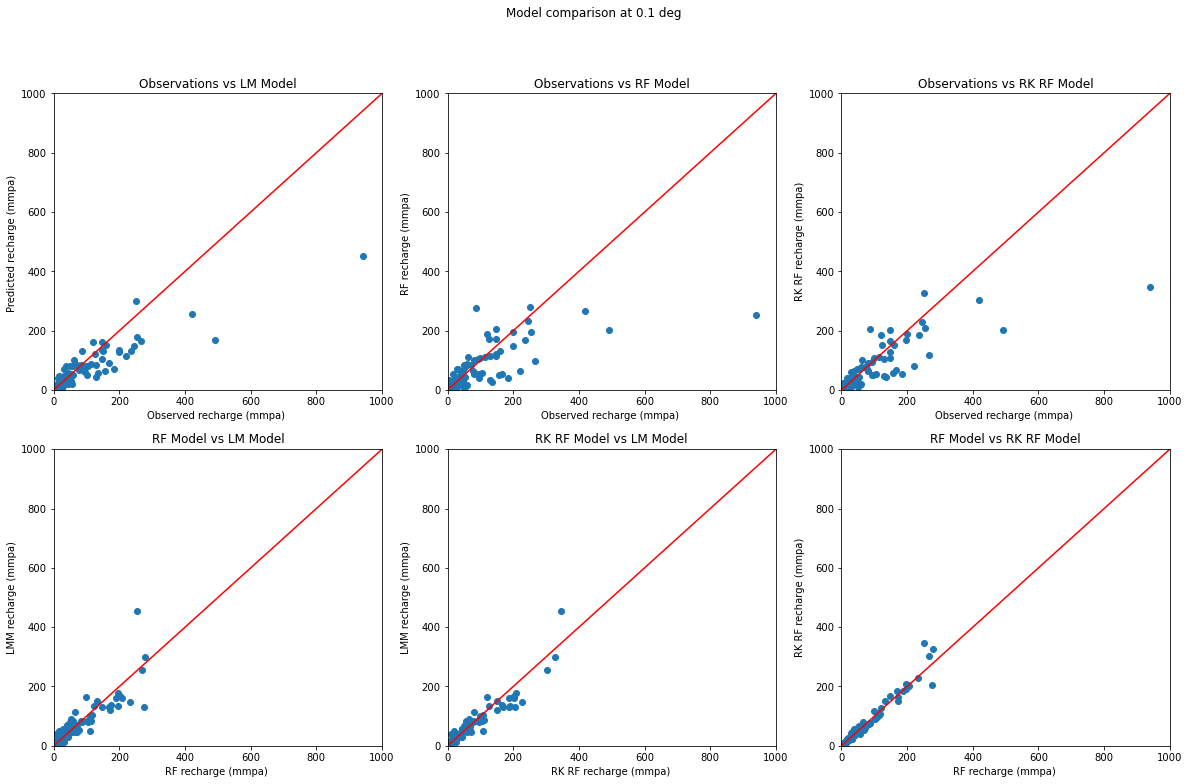

In [14]:
fig, axs = plt.subplots(2,3, figsize=(20,12))
fig.suptitle('Model comparison at 0.1 deg')
axs = axs.flatten()
axs[0].plot(summary['Observations'], summary['LMM'],marker='o',linestyle='')
axs[0].plot(range(0,1000), range(0,1000), 'r')
axs[0].set_xlabel('Observed recharge (mmpa) ')
axs[0].set_ylabel('Predicted recharge (mmpa) ')
axs[0].set_xlim([0,1000])
axs[0].set_title('Observations vs LM Model')
axs[0].set_ylim([0,1000])

axs[1].plot(summary['Observations'], summary['RF'],marker='o',linestyle='')
axs[1].plot(range(0,1000), range(0,1000), 'r')
axs[1].set_xlabel('Observed recharge (mmpa) ')
axs[1].set_ylabel('RF recharge (mmpa) ')
axs[1].set_xlim([0,1000])
axs[1].set_title('Observations vs RF Model')
axs[1].set_ylim([0,1000])

axs[2].plot(summary['Observations'], summary['RK RF'],marker='o',linestyle='')
axs[2].plot(range(0,1000), range(0,1000), 'r')
axs[2].set_xlabel('Observed recharge (mmpa) ')
axs[2].set_ylabel('RK RF recharge (mmpa)')
axs[2].set_xlim([0,1000])
axs[2].set_title('Observations vs RK RF Model')
axs[2].set_ylim([0,1000])

axs[3].plot(summary['RF'], summary['LMM'],marker='o',linestyle='')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_xlabel('RF recharge (mmpa) ')
axs[3].set_ylabel('LMM recharge (mmpa)')
axs[3].set_xlim([0,1000])
axs[3].set_title('RF Model vs LM Model')
axs[3].set_ylim([0,1000])

axs[4].plot(summary['RK RF'], summary['LMM'],marker='o',linestyle='')
axs[4].plot(range(0,1000), range(0,1000), 'r')
axs[4].set_xlabel('RK RF recharge (mmpa) ')
axs[4].set_ylabel('LMM recharge (mmpa)')
axs[4].set_xlim([0,1000])
axs[4].set_title('RK RF Model vs LM Model')
axs[4].set_ylim([0,1000])

axs[5].plot(summary['RF'], summary['RK RF'],marker='o',linestyle='')
axs[5].plot(range(0,1000), range(0,1000), 'r')
axs[5].set_xlabel('RF recharge (mmpa) ')
axs[5].set_ylabel('RK RF recharge (mmpa)')
axs[5].set_xlim([0,1000])
axs[5].set_title('RF Model vs RK RF Model')
axs[5].set_ylim([0,1000])

In [ ]:
# get residuals for regression kriging in R
# residuals_file = pd.read_csv('residuals.csv')
# residuals_file['Res_01'] = list(labels) - train_predictions
# residuals_file.to_csv('residuals.csv', index=False)